# TP OpenMP - October 2022

Florian Rascoussier

Bastien Barbe

Ce notebook constitue une étude comparative des méthodes de parallélisation CUDA sur GPU pour différentes applications.

## Part 1 : Pi

Ce programme calcule la valeur de pi à la précision renseignée par l'utilisateur.

### Compilation

In [1]:
# script params
EXEC: bool = False

In [37]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
!nvcc -o bin/tp_cuda_part_1_pi_multiblock_1_threadperblock tp_cuda_part_1_pi_multiblock_1_threadperblock.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread tp_cuda_part_1_pi_multithread.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread_shared tp_cuda_part_1_pi_multithread_shared.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread_full_reduction tp_cuda_part_1_pi_multithread_full_reduction.cu -O3 -g

# cuda-memcheck ./bin/tp_cuda_part_1_pi_basic -T 1000 -N 100000

### Performance evaluation

In [2]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'B': int,
    'T': int,
    'N': int,
    'runtime' : float
}

B_values = [1, 32, 64, 128, 256]
N_values = [100, 1000, 10000, 100000, 1000000]
T_values = [1, 32, 64, 128, 256]

# heatmap for N, B, T

color_class = {
    "onethreadperblock": "red",
    "multithread": "orange",
    "multithread_shared": "blue",
    "multithread_reduction": "green"
}

repeats = 10

In [44]:
import os
import subprocess

def delete_old_csv_file():
    try:
        os.remove(csv_result_file)
    except OSError:
        pass

def create_csv_file():
    print(f"Creating NEW CSV file ({csv_result_file})")
    f = open(csv_result_file, "w")
    f.write(",".join(csv_headers.keys()) + "\n")
    f.close()

# execute the programs
def run_program(
    program_filepath: str, B: int, T: int, N: int
):
    args = (program_filepath, 
        "-B", str(B), 
        "-T", str(T),
        "-N", str(N)
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

print("Program executions")
def exec_instances():
    for B in B_values:
        for T in T_values:
            for N in N_values:
                print(f" + Running programs (B: {B}, T: {T}, N: {N})")
                for _ in range(repeats):
                    run_program("bin/tp_cuda_part_1_pi_multiblock_1_threadperblock", B,T,N)
                    run_program("bin/tp_cuda_part_1_pi_multithread", B,T,N)
                    run_program("bin/tp_cuda_part_1_pi_multithread_shared", B,T,N)
                    run_program("bin/tp_cuda_part_1_pi_multithread_full_reduction", B,T,N)
                    print("*", end = '')
                print()

if EXEC:
    delete_old_csv_file()
    create_csv_file()
    exec_instances()
else: 
    print(f"WARN: EXEC = {EXEC}. No C++ program execution.")



Program executions
Creating NEW CSV file (stats.csv)
 + Running programs (B: 1, T: 1, N: 100)
**********
 + Running programs (B: 1, T: 1, N: 1000)
**********
 + Running programs (B: 1, T: 1, N: 10000)
**********
 + Running programs (B: 1, T: 1, N: 100000)
**********
 + Running programs (B: 1, T: 1, N: 1000000)
**********
 + Running programs (B: 1, T: 32, N: 100)
**********
 + Running programs (B: 1, T: 32, N: 1000)
**********
 + Running programs (B: 1, T: 32, N: 10000)
**********
 + Running programs (B: 1, T: 32, N: 100000)
**********
 + Running programs (B: 1, T: 32, N: 1000000)
**********
 + Running programs (B: 1, T: 64, N: 100)
**********
 + Running programs (B: 1, T: 64, N: 1000)
**********
 + Running programs (B: 1, T: 64, N: 10000)
**********
 + Running programs (B: 1, T: 64, N: 100000)
**********
 + Running programs (B: 1, T: 64, N: 1000000)
**********
 + Running programs (B: 1, T: 128, N: 100)
**********
 + Running programs (B: 1, T: 128, N: 1000)
**********
 + Running program

### Performance analysis

,version,B,T,N,runtime
0,onethreadperblock,1,1,100,0.063547
1,multithread,1,1,100,0.060030
2,multithread_shared,1,1,100,0.065639
3,multithread_reduction,1,1,100,0.069023
4,onethreadperblock,1,1,100,0.064787
5,multithread,1,1,100,0.041194
6,multithread_shared,1,1,100,0.041210
7,multithread_reduction,1,1,100,0.042250
8,onethreadperblock,1,1,100,0.063064
9,multithread,1,1,100,0.060549


/home/bastien/miniconda3/envs/py310omp/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/bastien/miniconda3/envs/py310omp/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/bastien/miniconda3/envs/py310omp/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/bastien/miniconda3/envs/py310omp/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/bastien/minico

lower_bound: 0.012937989374999997, upper_bound: 0.637512897125


Text(0.5, 0.98, 'Compute Pi with CUDA optimized for different configurations')

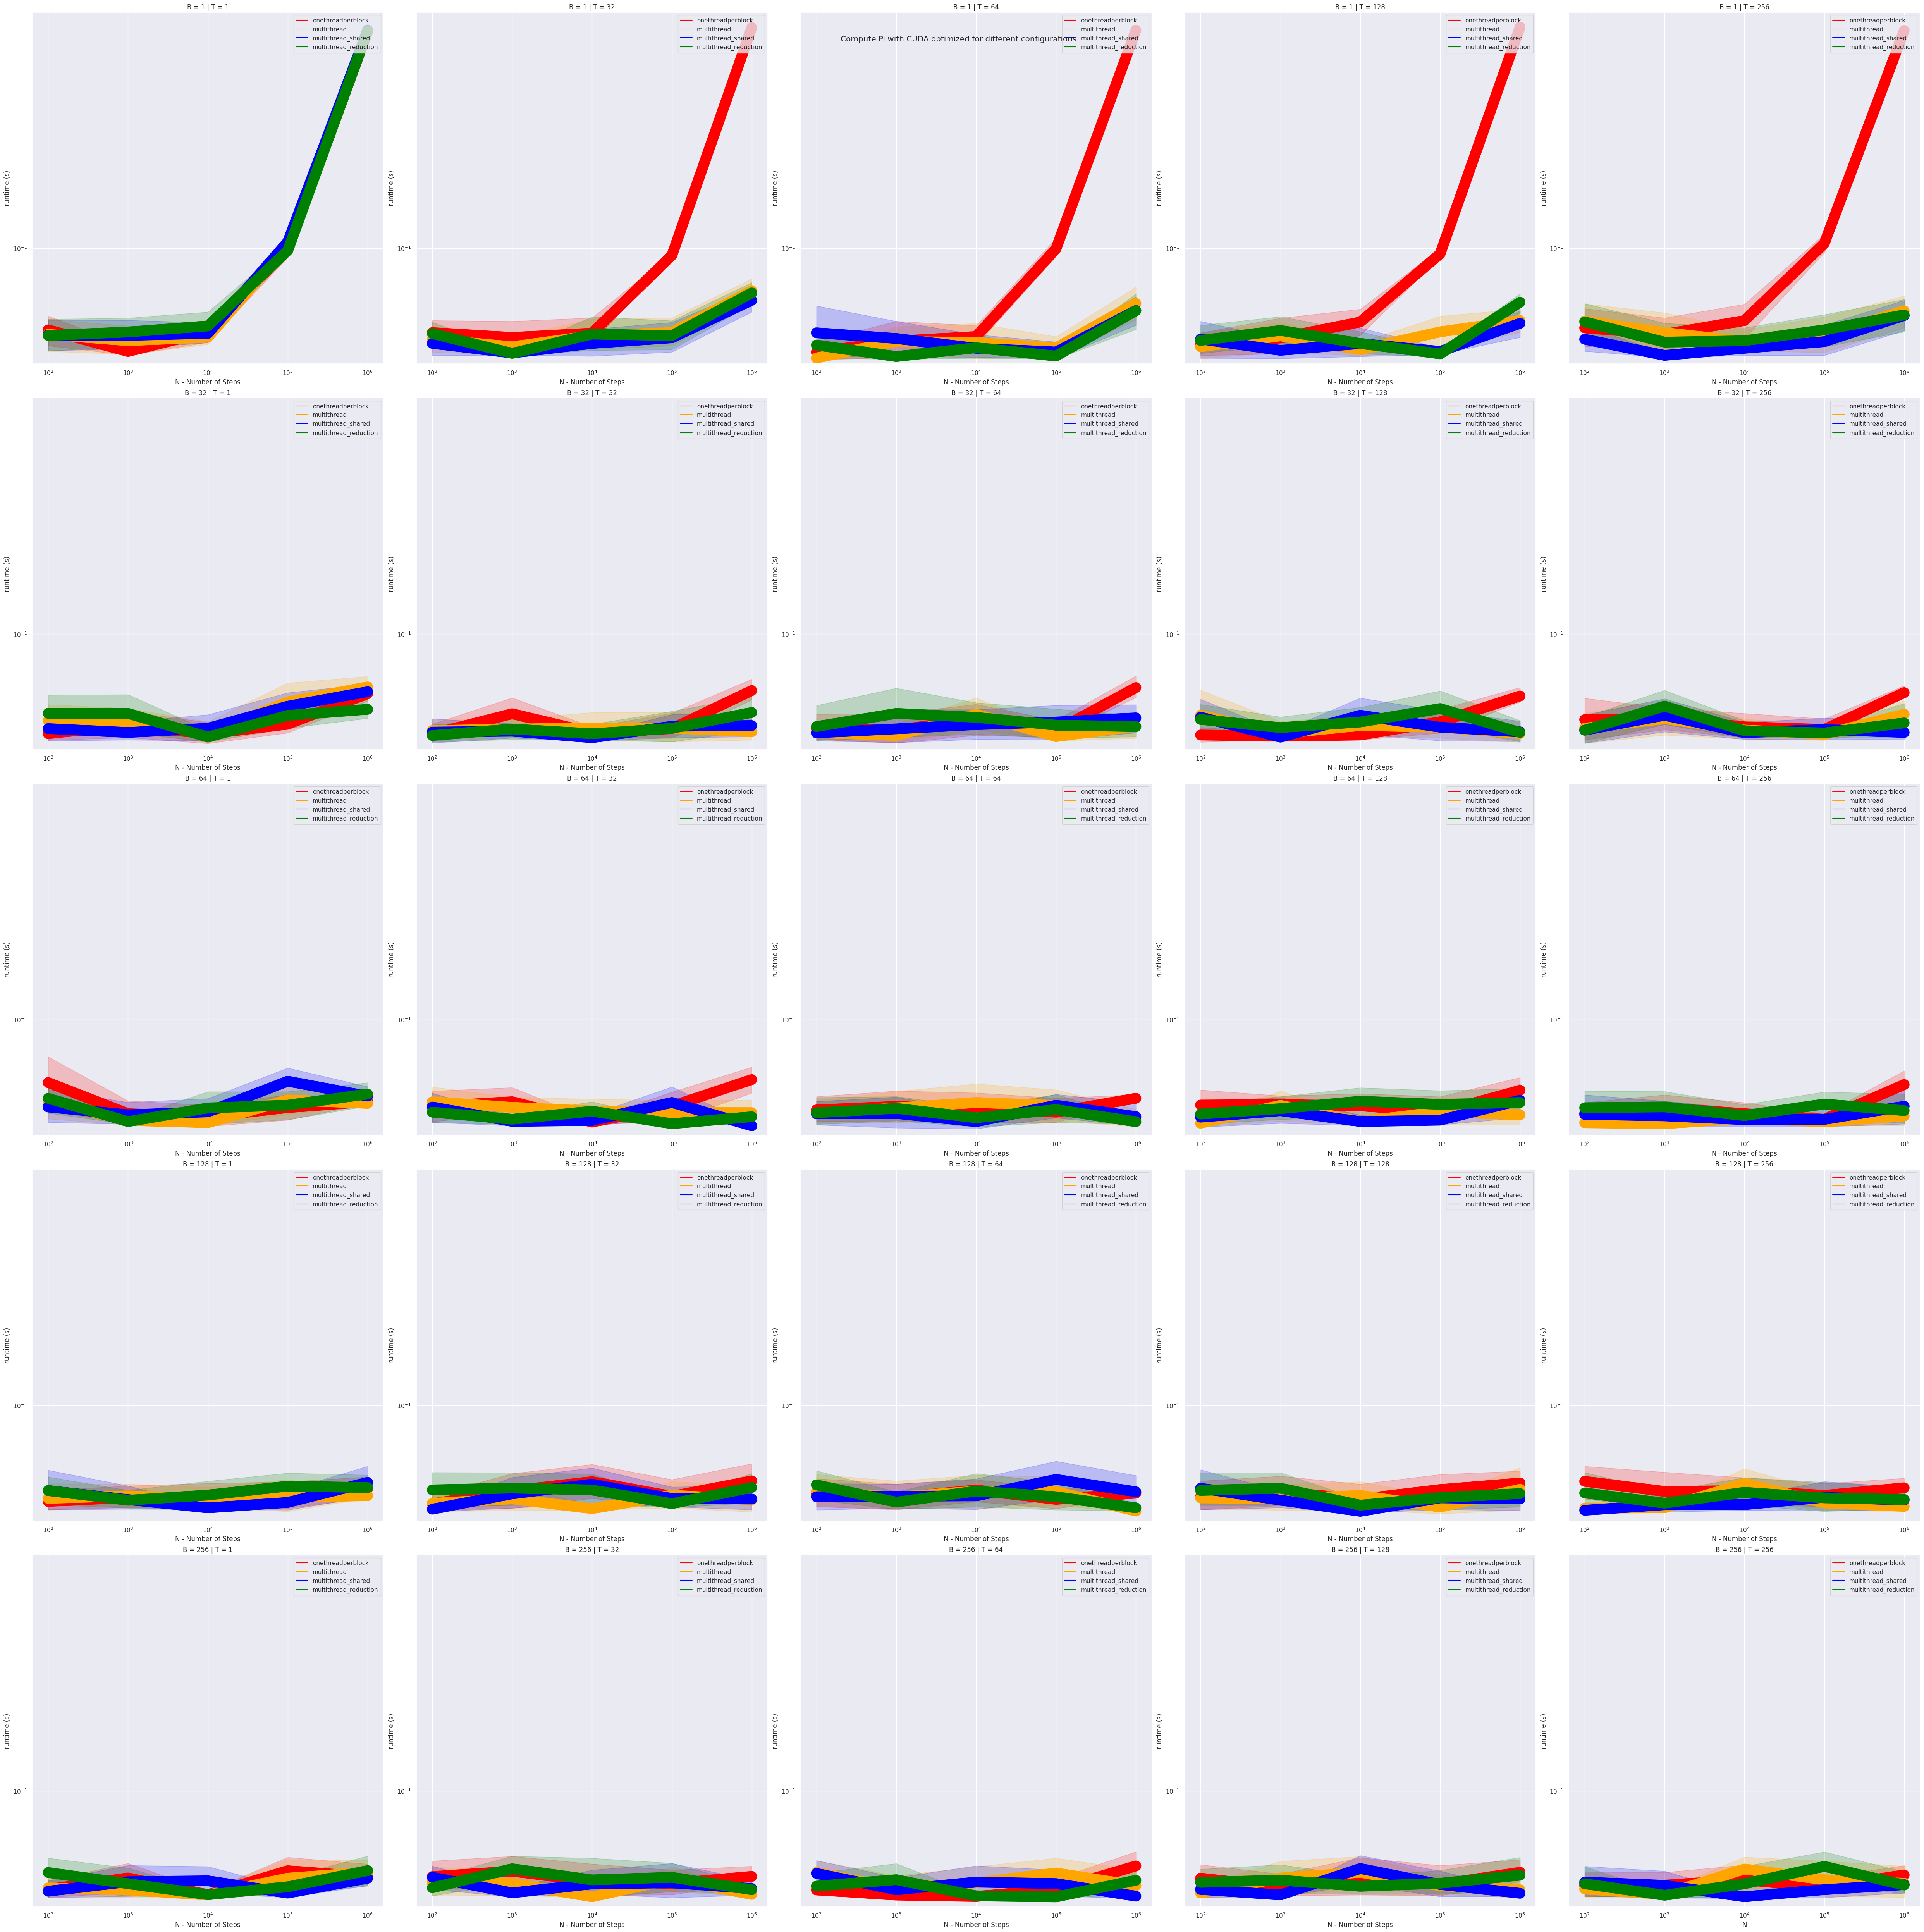

In [15]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]

#fig, ax = plt.subplots(figsize=(18,16))
#fig.suptitle(f"Compute Pi with CUDA optimized for different configurations")

# display legend for hue inside the subplots
g = sns.FacetGrid(
    data=df, 
    hue="version",
    col="T",
    row="B",
    palette=color_class, 
    height=10, 
    legend_out=True,
    despine=False,
    sharex=False,
    sharey=False
).map(sns.lineplot, "N", "runtime").set(xlabel="N - Number of Steps", ylabel="runtime (s)")


# set y axis to the same scale
# lower_bound = min([ax.get_ylim()[0] for ax in g.axes.flat])
# upper_bound = max([ax.get_ylim()[1] for ax in g.axes.flat])
for ax in g.axes.flat:
    ax.set_ylim(df.runtime.min(), df.runtime.max())
    # display legend for every subplot
    ax.legend(loc='upper right')
    # increase thickness of the lines
    for line in ax.lines:
        line.set_linewidth(20)
    # add legend for x and y axis for every subplot
    ax.set_xscale("log")
    ax.set_yscale("log")

# add legend for x and y axis
plt.xlabel("N")
plt.ylabel("runtime (s)")

# add graph title
g.figure.suptitle(f"Compute Pi with CUDA optimized for different configurations")

# # display legend for hue outside the subplots above the graph
# plt.legend(
#     title="version",
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.05),
#     fancybox=True,
#     shadow=True,
#     ncol=5
# )


### Discussion

Sur la première ligne, on peut remarquer clairement la ligne rouge correspondant au programme `onethreadperblock`. Celle-ci se démarque des autres, notamment parce qu'elle ne change pas malgré l'augmentation du nombre de threads. C'est un résultat attendu puisque dans ce programme, le nombre de threads par bloc est toujours fixé à 1. Ses performances sont donc moindres face à l'augmentation du nombre de calculs (N) par rapport aux autres programmes qui utilisent le multithreading. Pour cette première ligne, on peut aussi noter une légère amélioration des performances pour les programmes utilisant le multithreading GPU quand T augmente. Distinguer le meilleur programme dans les 3 restants est cependant difficile, tant les courbes et les intervalles de confiance se croisent et se chevauchent.



